In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable  # CHECK: do I need this?

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import seaborn

# from plots at the end -- TODO: try doing this only with PyTorch.
from scipy.stats import norm

### Simulate data

In [2]:
input_size = 2   # input is theta and z_i
output_size = 2  # output is mu_i and log(sigma_i) 
nn_width = 15

class likelihood_NN(nn.Module):
    
    def __init__(self):
        super(likelihood_NN, self).__init__()
        self.m1 = nn.Linear(input_size, nn_width)
        self.m2 = nn.Linear(nn_width, nn_width)
        self.m3 = nn.Linear(nn_width, 1)
        
        self.s1 = nn.Linear(input_size, nn_width)
        self.s2 = nn.Linear(nn_width, nn_width)
        self.s3 = nn.Linear(nn_width, 1)
        
    def forward_mean(self, theta, z):
#         nn_input = torch.zeros([n, 2])
#         nn_input[:, 0] = theta_rep
#         nn_input[:, 1] = z
#         m = F.relu(self.m1(nn_input))
#         m = F.relu(self.m2(m))
#         m = self.m3(m)
        m = theta + torch.sin(z) * z + z
        return m
    
    def forward_sd(self, theta, z):
#         nn_input = torch.zeros([n, 2])
#         nn_input[:, 0] = theta_rep
#         nn_input[:, 1] = z
#         s = F.relu(self.s1(nn_input))
#         s = F.relu(self.s2(s))
#         s = self.s3(s)
        s = torch.cos(z)
        return s
    

In [3]:
torch.manual_seed(1789)
likelihood_nn = likelihood_NN()

theta = torch.randn(1)

n = 10000
theta_rep = theta.repeat(n)
z = 5 * torch.randn(n)
x = torch.randn(n, 1)

f_mean = likelihood_nn.forward_mean(theta, z)
f_sd = likelihood_nn.forward_sd(theta, z)

x = f_mean.reshape(n, 1) + x * torch.exp(f_sd).reshape(n, 1)


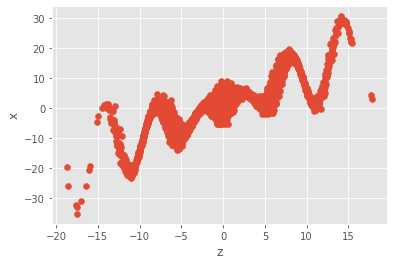

In [15]:
# Let's examine the data, in particular, plot x as a function of z.
# plt.scatter(z.detach.numpy(), x.detach.numpy())
plt.scatter(z.detach().numpy(), x.detach().numpy())
# plt.scatter(z.detach().numpy(), f_mean.detach().numpy(), marker = '^')
plt.xlabel("z")
plt.ylabel("x")
plt.savefig("to_discuss/z_deep.pdf")
plt.show()


<ipython-input-11-a6a28ff682f1>:7: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


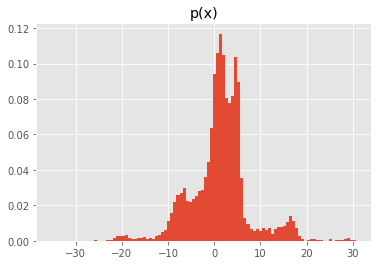

In [11]:
# plot x
nbins = 100
fig, axs = plt.subplots(1, 1)
axs.hist(x.detach().numpy(), bins = nbins, density = True)
axs.set_title("p(x)")
fig.savefig("to_discuss/p_deep.pdf")
fig.show()

In [5]:
if (False):
    for layer in likelihood_nn.children():
        if isinstance(layer, nn.Linear):
            print("weight", layer.state_dict()['weight'])
            print("bias", layer.state_dict()['bias'])

### Distributions for ELBO
Can use the same distributions for factorized and amortized VI. For amorizted VI, the arguments `nu_mean_z` and `nu_sd_z` will be the output of the inference network. Note that the joint $p(x, \theta, z)$ uses the known likelihood network.

In [14]:
def log_joint(x, theta, z):
    f_mean = likelihood_nn.forward_mean(theta, z).reshape(n, 1)
    f_sd = likelihood_nn.forward_sd(theta, z).reshape(n, 1)
        
    return -0.5 * torch.sum(z**2) - torch.sum(torch.div((x - f_mean)**2,
                                              2 * torch.exp(f_sd)**2))

def log_q(theta, z, nu_mean_theta, nu_sd_theta, nu_mean_z, nu_sd_z):
    log_q_theta = - torch.log(nu_sd_theta) - 1 / (2 * nu_sd_theta**2)\
                    * (theta - nu_mean_theta)**2
    log_q_z = torch.sum(- torch.log(nu_sd_z) - 1 / (2 * nu_sd_z**2) * (z - nu_mean_z)**2)
    return log_q_theta + log_q_z

### Model class for amortized VI

In [15]:
# Architecture for the inference network (for now stick to three layers.)
inf_input_size = 1  # inference network only takes in x_i

class MCElbo_AVI(torch.nn.Module):
    def __init__(self, inf_nn_width):
        super(MCElbo_AVI, self).__init__()

        # variational parameters for q(theta) # ToDO: set initial value
        self.nu_mean_theta = torch.nn.Parameter(torch.randn(1, 1), requires_grad = True)
        self.nu_sd_theta_log = torch.nn.Parameter(torch.randn(1, 1), requires_grad = True)
        
        # define inference neural network for the mean
        self.m1 = nn.Linear(inf_input_size, inf_nn_width)
        self.m2 = nn.Linear(inf_nn_width, inf_nn_width)
        self.m3 = nn.Linear(inf_nn_width, 1)
        
        # define inference neural network for the log sd
        self.s1 = nn.Linear(inf_input_size, inf_nn_width)
        self.s2 = nn.Linear(inf_nn_width, inf_nn_width)
        self.s3 = nn.Linear(inf_nn_width, 1)

        self.mc_samples = 10
        
    def forward_mean(self, x):
        y = F.relu(self.m1(x))
        y = F.relu(self.m2(y))
        y = self.m3(y)
        return y
    
    def forward_log_sd(self, x):
        y = F.relu(self.s1(x))
        y = F.relu(self.s2(y))
        y = self.s3(y)
        return y
    
    def generate_rand(self):
        eps_theta = torch.randn((1, 1))
        eps_z = torch.randn((n, 1))
        return eps_theta, eps_z
    
    def reparam(self, eps_theta, eps_z, nu_mean_z, nu_sd_z):
        return eps_theta.mul(torch.exp(self.nu_sd_theta_log)).add(self.nu_mean_theta),\
               eps_z.mul(nu_sd_z).add(nu_mean_z)

    def compute_elbo_sample(self, nu_mean_z, nu_sd_z, x):
        eps_theta, eps_z = self.generate_rand()
        theta, z = self.reparam(eps_theta, eps_z, nu_mean_z, nu_sd_z)

        Elbo = log_joint(x, theta, z) - log_q(theta, z,
                           self.nu_mean_theta, torch.exp(self.nu_sd_theta_log),
                           nu_mean_z, nu_sd_z)
        return Elbo
    
    def compute_elbo(self, x):
        nu_mean_z = self.forward_mean(x.reshape(n, 1))
        nu_sd_z = torch.exp(self.forward_log_sd(x.reshape(n, 1)))
        
        Elbo_mean = self.compute_elbo_sample(nu_mean_z, nu_sd_z, x)
        for i in range(1, self.mc_samples):
            Elbo_mean = i * Elbo_mean / (i + 1) + self.compute_elbo_sample(nu_mean_z, nu_sd_z, x)\
                                                                                     / (i + 1)
        return Elbo_mean
    
    # Additional function to create a common initialization with FVI
    def FVI_param(self, x):
        nu_mean_z = self.forward_mean(x.reshape(n, 1))
        nu_sd_z = self.forward_log_sd(x.reshape(n, 1))
        
        return self.nu_mean_theta, self.nu_sd_theta_log, nu_mean_z, nu_sd_z


### Factorized VI

In [135]:
# Initialize the weights and biases to 0.
# This amounts to starting with all q(z_i)'s a standard Gaussian.
def init_weights(m):
    if isinstance(m, nn.Linear):
        m.weight.data.fill_(0.01)
        m.bias.data.fill_(0.01)


In [141]:
# Initialisation for FVI
# Generate initial values for variational parameters and use them to initialize FVI.
torch.manual_seed(1954)
init_nn_width = 2
model_av = MCElbo_AVI(init_nn_width)
# model_av.apply(init_weights)

# NOTE: by default, parameters of the inference NN are initialized at the same value,
# which means the elements of nu_mean_z and nu_sd_z_log have the same starting value.
nu_mean_theta_init, nu_sd_theta_log_init, nu_mean_z, nu_sd_z = model_av.FVI_param(x)
nu_mean_z_init = nu_mean_z.reshape(n, 1)
nu_sd_z_log_init = nu_sd_z.reshape(n, 1)


In [142]:
class MCElbo_meanfield(nn.Module):
    def __init__(self):
        super(MCElbo_meanfield, self).__init__()

        # Use common initialization
        self.nu_mean_theta = torch.nn.Parameter(nu_mean_theta_init, requires_grad = True)
        self.nu_sd_theta_log = torch.nn.Parameter(nu_sd_theta_log_init, requires_grad = True)
        self.nu_mean_z = torch.nn.Parameter(nu_mean_z_init, requires_grad = True)
        self.nu_sd_z_log = torch.nn.Parameter(nu_sd_z_log_init, requires_grad = True)

        self.mc_samples = 10

    def generate_rand(self):
        eps_theta = np.random.normal(size = (1, 1))
        eps_z = np.random.normal(size = (n, 1))
        
        return eps_theta, eps_z

    def reparam(self, eps_theta, eps_z):
        eps_theta = Variable(torch.FloatTensor(eps_theta))
        eps_z = Variable(torch.FloatTensor(eps_z))
        return eps_theta.mul(torch.exp(self.nu_sd_theta_log)).add(self.nu_mean_theta),\
               eps_z.mul(torch.exp(self.nu_sd_z_log)).add(self.nu_mean_z)
    
    def compute_elbo_sample(self, x):
        eps_theta, eps_z = self.generate_rand()
        theta, z = self.reparam(eps_theta, eps_z)

        # Compute Elbo integrand using mc_samples draws
        Elbo = log_joint(x, theta, z)\
                   - log_q(theta, z,
                           self.nu_mean_theta, torch.exp(self.nu_sd_theta_log),
                           self.nu_mean_z, torch.exp(self.nu_sd_z_log))

        return Elbo
    
    def compute_elbo(self, x):       
        Elbo_mean = self.compute_elbo_sample(x)
        for i in range(1, self.mc_samples):
            Elbo_mean = i * Elbo_mean / (i + 1) + self.compute_elbo_sample(x) / (i + 1)

        return Elbo_mean  


In [143]:
# Sanity check: make sure both models return the same ELBO (within Monte Carlo error)
model = MCElbo_meanfield()
print("loss (FVI): ", model.compute_elbo(x))
print("-----")
print("loss (AVI): ", model_av.compute_elbo(x))

loss (FVI):  tensor([[-657795.3125]], grad_fn=<AddBackward0>)
-----
loss (AVI):  tensor([[-696516.8750]], grad_fn=<AddBackward0>)


In [144]:
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-2)  # 1e-2
x_torch = Variable(torch.tensor(x), requires_grad = False)

n_iter_optimizer = int(20e3)
loss_saved = np.empty((n_iter_optimizer,))

for i in range(n_iter_optimizer):
    loss = - model.compute_elbo(x_torch)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_saved[i] = loss.data.numpy()
    if i % 1000  == 0:
        # for now, only keep track of the variational parameters of theta
        print("loss", loss.data.numpy())
        print(model.nu_mean_theta.data.numpy(), torch.exp(model.nu_sd_theta_log).data.numpy())


<ipython-input-144-a5ee7eb7a154>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_torch = Variable(torch.tensor(x), requires_grad = False)


loss [[679322.9]]
[[0.32128695]] [[2.0042746]]
loss [[77656.555]]
[[2.9605227]] [[0.46549883]]
loss [[41964.22]]
[[1.5566299]] [[0.29137334]]
loss [[35308.69]]
[[1.0637325]] [[0.19629453]]
loss [[33557.137]]
[[1.0800864]] [[0.14161436]]
loss [[33229.543]]
[[1.0968407]] [[0.10567477]]
loss [[33139.98]]
[[1.0976204]] [[0.08076167]]
loss [[33132.812]]
[[1.0994636]] [[0.06247125]]
loss [[33115.797]]
[[1.0857769]] [[0.04887917]]
loss [[33121.227]]
[[1.0910693]] [[0.038866]]
loss [[33110.375]]
[[1.093113]] [[0.03152919]]
loss [[33113.64]]
[[1.0855223]] [[0.02623697]]
loss [[33106.72]]
[[1.0954833]] [[0.0228243]]
loss [[33089.695]]
[[1.0848533]] [[0.02081224]]
loss [[33109.016]]
[[1.0916249]] [[0.01990989]]
loss [[33099.25]]
[[1.0919243]] [[0.0198657]]
loss [[33112.23]]
[[1.094371]] [[0.01943142]]
loss [[33114.062]]
[[1.0926062]] [[0.01987766]]
loss [[33098.566]]
[[1.0816594]] [[0.02006174]]
loss [[33116.29]]
[[1.1022004]] [[0.02015166]]


loss [[33100.863]]
[[1.082445]] [[0.02105705]]


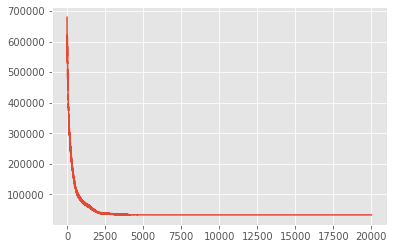

In [145]:
# Get final result from training model
print("loss", loss.data.numpy())
mf_mean_theta = model.nu_mean_theta.data.numpy()
mf_sd_theta = torch.exp(model.nu_sd_theta_log).data.numpy()
print(mf_mean_theta, mf_sd_theta)

plt.plot(loss_saved)

### Amortized VI

In [80]:
0 % 1000 == 0

True

In [117]:
def run_avi(inf_nn_width, seed, n_iter_optimizer):
    torch.manual_seed(seed)
    model_av = MCElbo_AVI(inf_nn_width)
    # model_av.apply(init_weights)
    
    optimizer = torch.optim.Adam(model_av.parameters(), lr = 1e-2)
    
    loss_av_saved = np.empty(n_iter_optimizer)
    for i in range(n_iter_optimizer):
        loss_av = - model_av.compute_elbo(x_torch)
        optimizer.zero_grad()
        loss_av.backward()
        optimizer.step()
        loss_av_saved[i] = loss_av
        if i % 1000 == 0:
            print("loss", loss_av.data.numpy())
    return loss_av_saved

In [122]:
seed = 1954
n_iter_optimizer = int(20e3)

loss_av_1_saved = run_avi(1, seed , n_iter_optimizer)
loss_av_2_saved = run_avi(2, seed, n_iter_optimizer)
loss_av_4_saved = run_avi(4, seed , n_iter_optimizer)
loss_av_8_saved = run_avi(8, seed, n_iter_optimizer)
loss_av_16_saved = run_avi(16, seed , n_iter_optimizer)
loss_av_24_saved = run_avi(24, seed, n_iter_optimizer)
# etc.

loss [[260162.47]]
loss [[37396.883]]
loss [[37355.348]]
loss [[37274.875]]
loss [[37230.168]]
loss [[37150.48]]
loss [[37219.484]]
loss [[37225.676]]
loss [[37262.85]]
loss [[37261.406]]
loss [[37235.145]]
loss [[37204.77]]
loss [[37230.062]]
loss [[37232.676]]
loss [[37264.47]]
loss [[37254.91]]
loss [[37247.773]]
loss [[37233.848]]
loss [[37149.875]]
loss [[37329.207]]
loss [[696516.9]]
loss [[34490.7]]
loss [[34260.37]]
loss [[34281.527]]
loss [[34243.73]]
loss [[34277.68]]
loss [[34199.35]]
loss [[34234.63]]
loss [[34215.527]]
loss [[34217.414]]
loss [[34219.07]]
loss [[34200.113]]
loss [[34251.25]]
loss [[34203.844]]
loss [[34231.746]]
loss [[34246.62]]
loss [[34212.316]]
loss [[34242.52]]
loss [[34197.426]]
loss [[34232.45]]
loss [[981180.6]]
loss [[69284.5]]
loss [[69431.81]]
loss [[69453.67]]
loss [[69118.67]]
loss [[69302.484]]
loss [[69106.81]]
loss [[69396.83]]
loss [[45798.414]]
loss [[43748.6]]
loss [[55428.914]]
loss [[54187.254]]
loss [[53683.156]]
loss [[36161.133]]
lo

In [152]:
loss_av_32_saved = run_avi(32, seed, n_iter_optimizer)

loss [[330519.75]]
loss [[nan]]
loss [[nan]]
loss [[nan]]
loss [[nan]]


KeyboardInterrupt: 

<ipython-input-150-8260118e432b>:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()


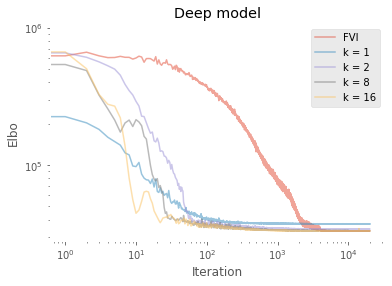

In [150]:
plt.plot(loss_saved, label = 'FVI', alpha = 0.5)
plt.plot(loss_av_1_saved, label = 'k = 1', alpha = 0.5)
plt.plot(loss_av_2_saved, label = 'k = 2', alpha = 0.5)
# plt.plot(loss_av_4_saved, label = 'k = 4', alpha = 0.5)
plt.plot(loss_av_8_saved, label = 'k = 8', alpha = 0.5)
plt.plot(loss_av_16_saved, label = 'k = 16', alpha = 0.5)
# plt.plot(loss_av_24_saved, label = 'k = 24', alpha = 0.5)
plt.yscale("log")
plt.xscale("log")
plt.legend(loc = "best")
plt.title("Elbo, n = " + str(n))
ax = plt.gca()
#ax.set_ylim([32000, 130000])
plt.title("Deep model")
plt.xlabel("Iteration")
plt.ylabel("Elbo")

ax = plt.axes()
ax.set_facecolor("white")
plt.savefig("to_discuss/elbo_deep.pdf")
plt.show()


In [151]:
# Get asymptotic ELBO
index_center = 4500
window = 100
print("FVI: ", mean_window(loss_saved, 4500, window), " +/- ",
     sd_window(loss_saved, 4500, window))
print("k = 1: ", mean_window(loss_av_1_saved, 4500, window), " +/- ",
     sd_window(loss_av_1_saved, 4500, window))
print("k = 2: ", mean_window(loss_av_2_saved, 4500, window), " +/- ",
     sd_window(loss_av_2_saved, 4500, window))
print("k = 8: ", mean_window(loss_av_8_saved, 4500, window), " +/- ",
     sd_window(loss_av_8_saved, 4500, window))
print("k = 16: ", mean_window(loss_av_16_saved, 4500, window), " +/- ",
     sd_window(loss_av_16_saved, 4500, window))
print("k = 24: ", mean_window(loss_av_24_saved, 4500, window), " +/- ",
     sd_window(loss_av_24_saved, 4500, window))

FVI:  33306.768828125  +/-  36.37693370335052
k = 1:  37245.16447265625  +/-  48.31879346496577
k = 2:  34240.2598828125  +/-  20.800134349939302
k = 8:  33274.66951171875  +/-  16.97072570605686
k = 16:  33236.5179296875  +/-  14.173722887801324
k = 24:  33071.723515625  +/-  14.220643467032534


In [26]:
index_center = 4500
window = 10
print(np.mean(loss_saved[(index_center - window):(index_center + window)]))
print(np.std(loss_saved[(index_center - window):(index_center + window)]))

print(np.mean(loss_av_saved[(index_center - window):(index_center + window)]))
print(np.std(loss_av_saved[(index_center - window):(index_center + window)]))

14427.575244140626
10.01549769411398
14401.196826171876
14.69895580331285


In [1]:
def mean_window(loss, index_center, window):
    return np.mean(loss[(index_center - window):(index_center + window)])

def sd_window(loss, index_center, window):
    return np.std(loss[(index_center - window):(index_center + window)]) 

In [49]:
FVI = [mean_window(loss_saved, 100, 10),
      mean_window(loss_saved, 1000, 10),
      mean_window(loss_saved, 4500, 10)]

FVI_err = [sd_window(loss_saved, 100, 10),
          sd_window(loss_saved, 1000, 10),
          sd_window(loss_saved, 4500, 10)]

AVI = [mean_window(loss_av_saved, 100, 10),
      mean_window(loss_av_saved, 1000, 10),
      mean_window(loss_av_saved, 4500, 10)]

AVI_err = [sd_window(loss_av_saved, 100, 10),
          sd_window(loss_av_saved, 1000, 10),
          sd_window(loss_av_saved, 4500, 10)]

In [58]:
print("FVI: ", FVI)
print("AVI:", AVI)

FVI:  [17447.890625, 14440.43642578125, 14427.575244140626]
AVI: [15262.216162109375, 14630.1435546875, 14401.196826171876]


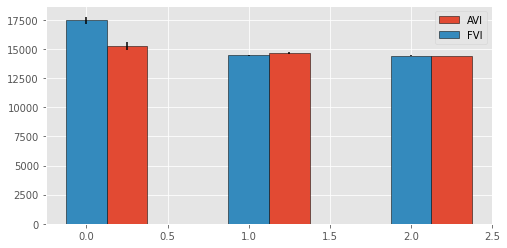

In [60]:
barWidth = 0.25
fig = plt.subplots(figsize = (8, 4))

br1 = np.arange(len(FVI))
br2 = [x + barWidth for x in br1]

plt.bar(br2, AVI, width = barWidth, edgecolor = 'black', yerr = AVI_err, label = 'AVI')
plt.bar(br1, FVI, width = barWidth, edgecolor = 'black', yerr = FVI_err, label = 'FVI')
plt.legend()